## Chapter 2: End-to-End ML Project
<i>Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.</i>

### Setup

The book's instructions start with fetching the code. The example in the book's github, however, start out with the imports, so I'll try those first.

In [2]:
# Python >=3.5 is required
import sys
assert sys.version_info >= (3, 5)

<b>Note:</b> I really wish I could see some error messages if these things don't run right. I want to put tests in my code as soon as I learn how.

In [3]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [4]:
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [5]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ML_HOUSING_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Download the Data

I'm using data from the book's github's updated content instead of the exact source listed in my 2017 edition of the book itself.

In [6]:
import os
import tarfile
import urllib.request #2017: from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/" #2017: "...handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Now when you call fetch_housing_data(), it creates a <i>datasets/housing</i> directory in your workspace, downloads the <i>housing.tgz</i> file, and extracts the <i>housing.csv</i> from it in this directory.

In [7]:
fetch_housing_data()

Time to load the data!

In [8]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [9]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Note that the total_bedrooms attribute only has 20,433 non-null values, which means it is missing 207 districts.

All attributes are numerical except ocean_proximity; it's an object, and because we got the data from a .csv, we know that object will be a text attribute. It also looked categorical in the head() view.

Let's see what categories there are:

In [11]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Inland, Near Ocean, Near Bay, or Island.

Now let's look at the numerical attributes:

In [12]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Interesting. Let's look at a couple points here:
1. The count of all attributes is the same as the count of instances (20,640) except for total_bedrooms, where there are apparently some null values not being counted  
2. Looking at the 50% percentile for housing_median_age: 50% of instances have housing_median_age 29 or less  
3. Looking at the percentiles for number of households: 25% of instances (districts) have no more than 280 households, 75% no more than 605, but the max is at 6,082, which means that top 25% probably carries at least one outlier  
4. Standard deviation for longitude and latitude hovers around 2, which I believe makes sense as those values should not include too much variance if we're sticking to a reasonable geography here  
5. Standard deviation for total rooms is 2,181, which seems extreme? I'm not sure how to read that

We'll plot the numerical attributes in histograms to get a better view of their properties.

Saving figure attribute_histogram_plots


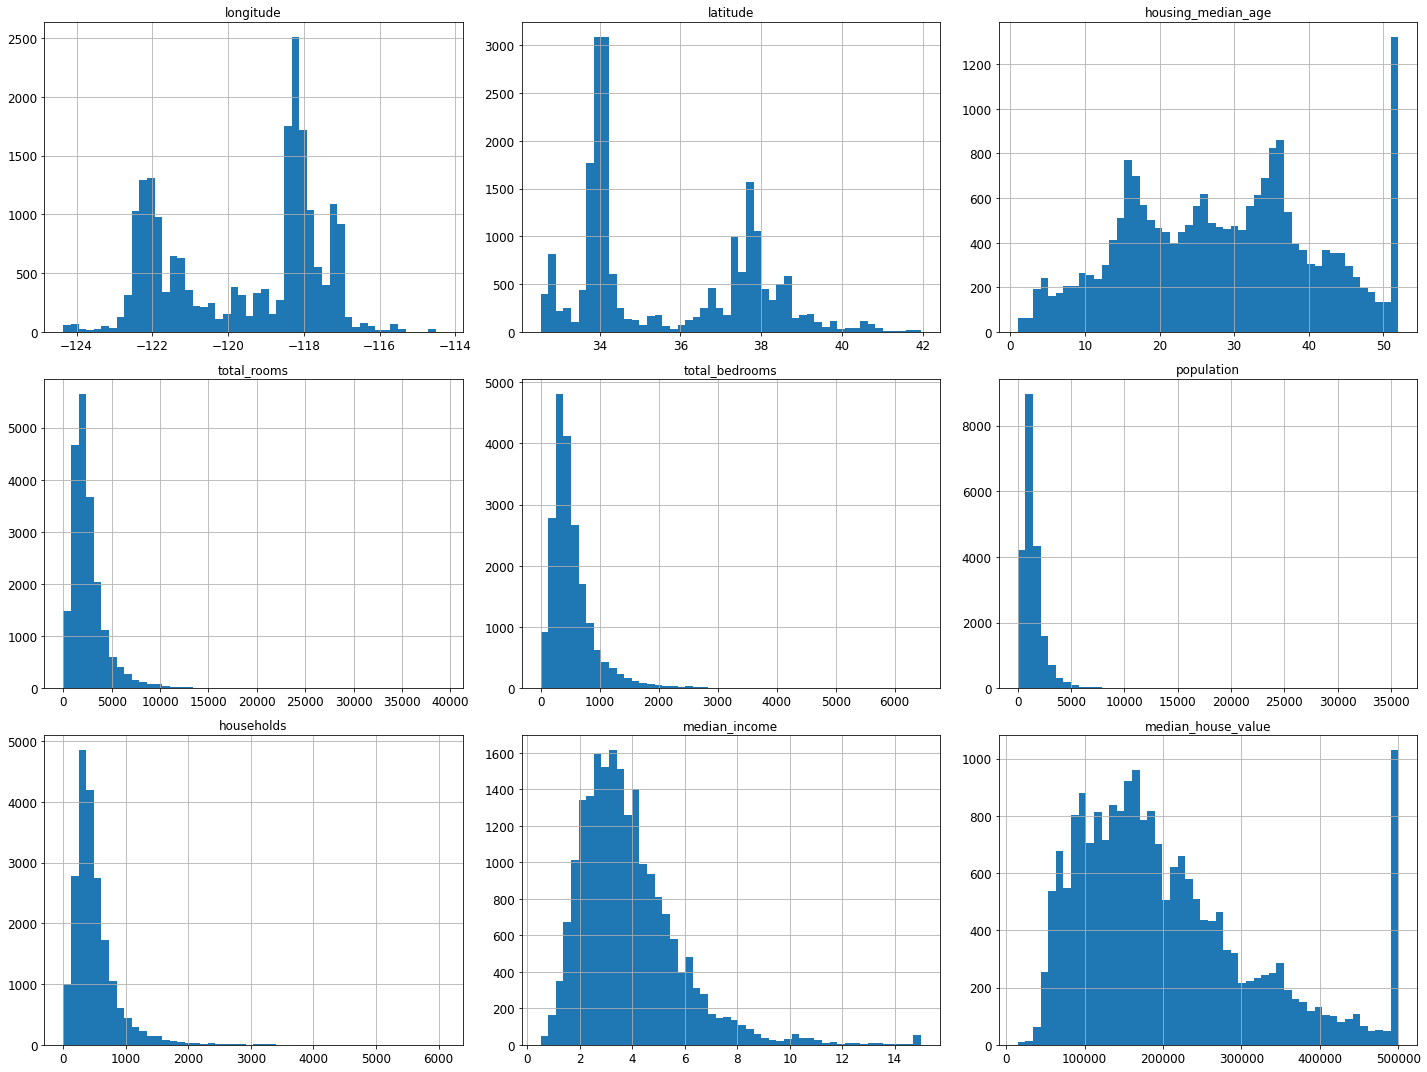

In [13]:
# We could plot each attribute at a time, but to save time let's call the hist() method on the whole dataset
# %matplotlib inline works in Jupyter notebooks and Google Colab, telling Matplotlib to use the notebook's graphical backend to draw on your screen
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

## Create a Test Set

To avoid "data snooping", which is when you look at test data and accidentally detect patterns that might bias you toward an over-fitted model, choose the test data at this stage and don't look at it again until it's needed.

There are several options to getting the test set. The following methods involve random sampling:
1. Pick 20% of the instances at random using `numpy.random.permutation()` to shuffle the set, then split out 0.2 (20%) into a separate index to get two random indices: training data (16512 instances) and test data (4128 instances)  

This only works once for a single set. If you run it again, you'll get a different set of test data, which will eventually cycle through the whole dataset, which we want to avoid.

2. Make the 20% selected above into a "permanent" test set: either save it from the first run and load it in subsequent runs, or set the random number generator's seed before calling `numpy.random.permutation()` so it always generates the same shuffled indices.  

This only works until we fetch an updated dataset.

3. Use a unique, immutable identifyer for each instance to separate out the 20%.

This method works because an updated dataset would have updated IDs. No new test set would contain any instances from a previous training set because that previous set would meet that hash parameter. However, the data does not have unique IDs, so we'll have to make some.

### Split the Dataset Using Random Sampling

I will split the set based on unique IDs, which will be calculated based on each district's latitude and longitude features.

In [14]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [15]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [16]:
housing_with_id = housing.reset_index() # adds an `index` column
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [17]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [18]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


### Split the Data Using Stratified Sampling

***Stratified Sampling***: the population is divided into homogeneous subgroups called *strata*, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population. Since we are going to use median income to predict median housing prices, we can create categories (buckets) to make sure our test set is representative of the population.

<AxesSubplot:>

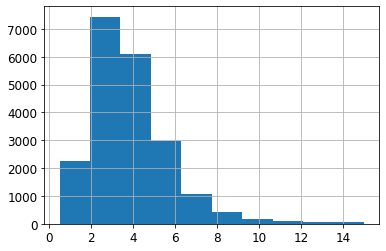

In [19]:
housing["median_income"].hist()

Looks like this distributes the data according to default bins. You can see most median incomes cluster around 50k, but some go far beyond $60k. I need to have a sufficient number of instances in my dataset for each stratum so the tratum's importance is not biased. This means I should not have too many strata, and each stratum shold be large enough.

Next, we'll create an income category attribute by dividing the median income by 1.5 (to limit the number of income categories) and rounding up using cell (to have discrete categories), then merging all the categories greater than 5 into category 5:

In [20]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [21]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

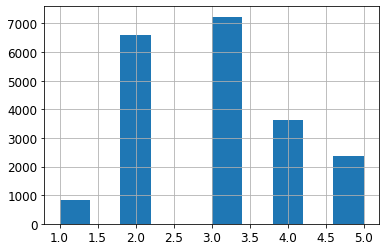

In [22]:
housing["income_cat"].hist()

Now I can do stratified smapling based on the income category using Scikit-Learn's StratifiedShuffleSplit class.

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [24]:
# Look at income category proportions in the test set:

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [25]:
# Look at the proportions in the overall dataset:

housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [26]:
# Compare income category proporions in the overall dataset with the test set 
# using stratified sampling and the test set using random sampling:

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [27]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


*The table above does not match the book or Geron's Github. Need to troubleshoot.*